In [68]:
from utils import  get_data, scale

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import mutual_info_classif, RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd

()
AUC:  0.6296296296296295
              precision    recall  f1-score   support

           0       0.62      0.59      0.60        27
           1       0.65      0.67      0.66        30

    accuracy                           0.63        57
   macro avg       0.63      0.63      0.63        57
weighted avg       0.63      0.63      0.63        57



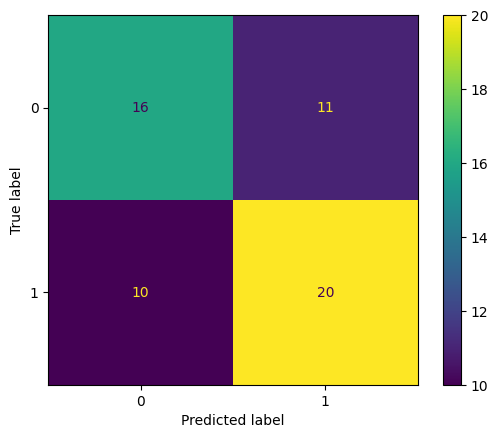

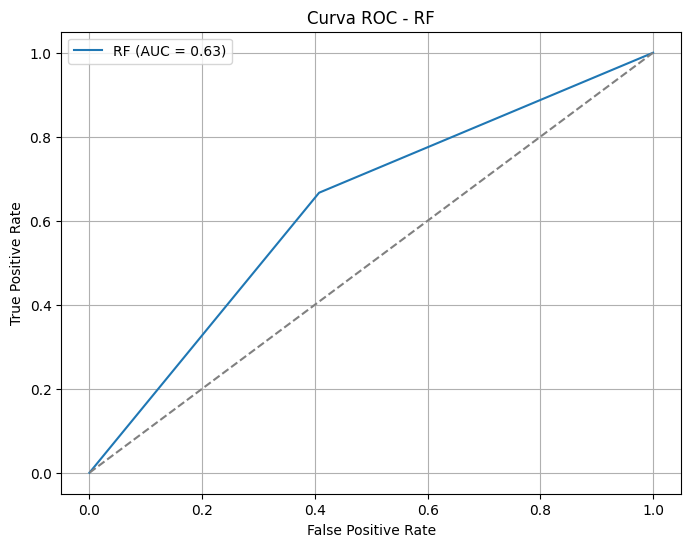

('adc',)
AUC:  0.5782019704433498
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        29
           1       0.58      0.54      0.56        28

    accuracy                           0.58        57
   macro avg       0.58      0.58      0.58        57
weighted avg       0.58      0.58      0.58        57



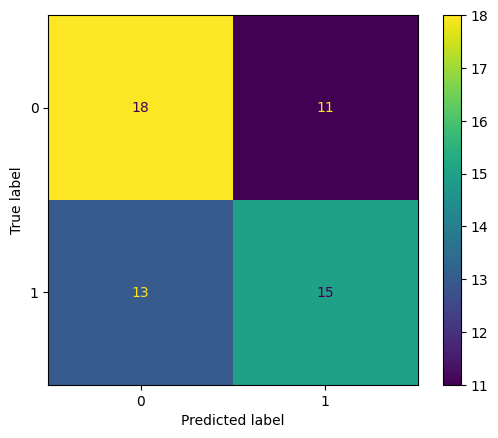

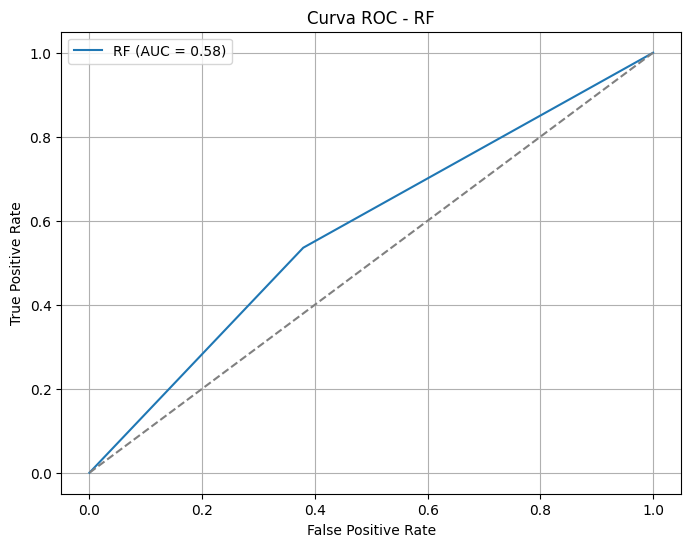

('hbv',)
AUC:  0.4722222222222222
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        27
           1       0.50      0.50      0.50        30

    accuracy                           0.47        57
   macro avg       0.47      0.47      0.47        57
weighted avg       0.47      0.47      0.47        57



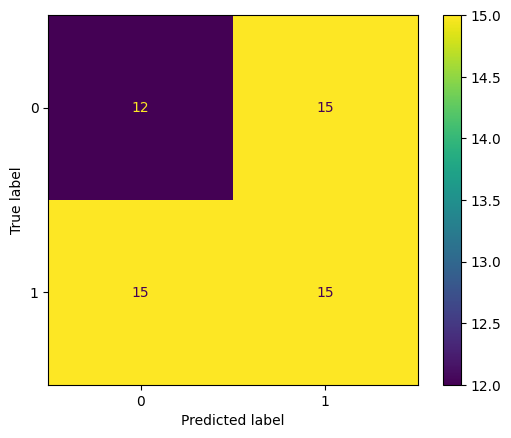

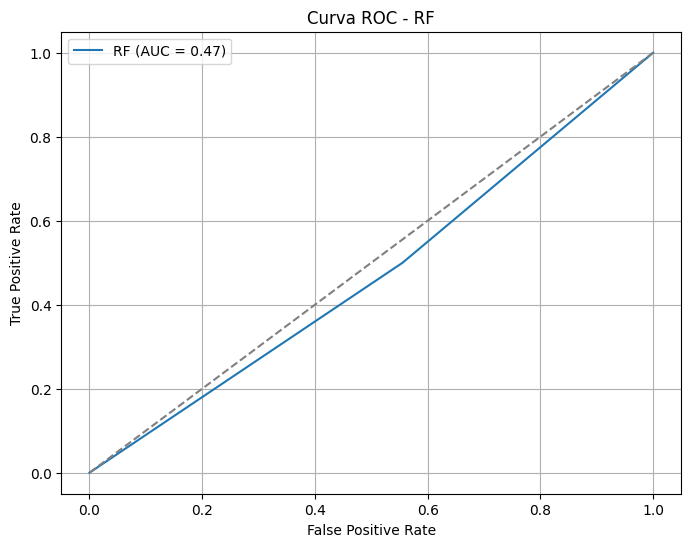

('t2w',)
AUC:  0.5925
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        25
           1       0.65      0.62      0.63        32

    accuracy                           0.60        57
   macro avg       0.59      0.59      0.59        57
weighted avg       0.60      0.60      0.60        57



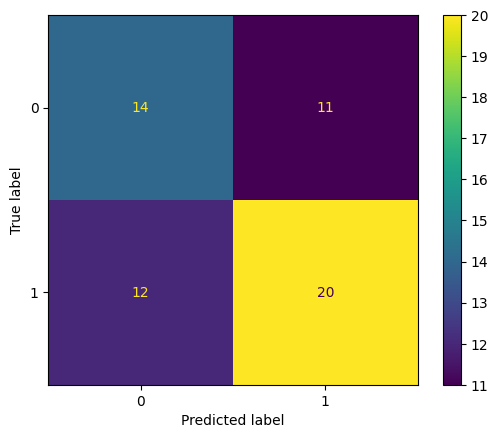

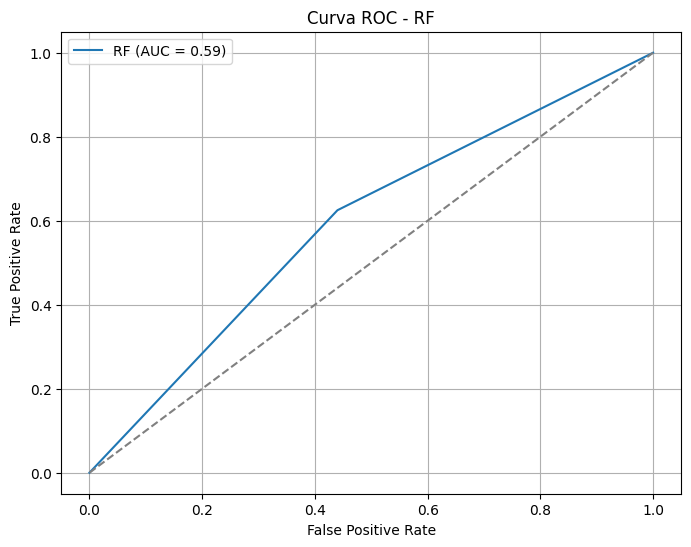

('adc', 'hbv')
AUC:  0.639375
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        25
           1       0.68      0.72      0.70        32

    accuracy                           0.65        57
   macro avg       0.64      0.64      0.64        57
weighted avg       0.65      0.65      0.65        57



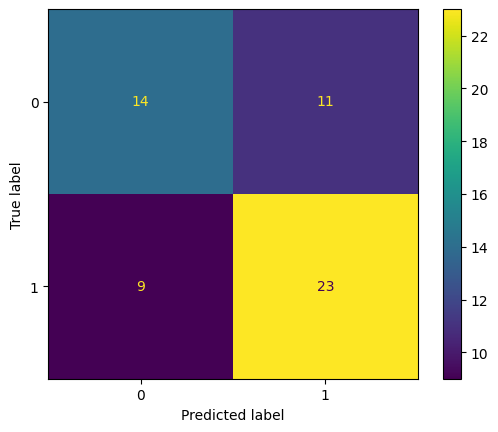

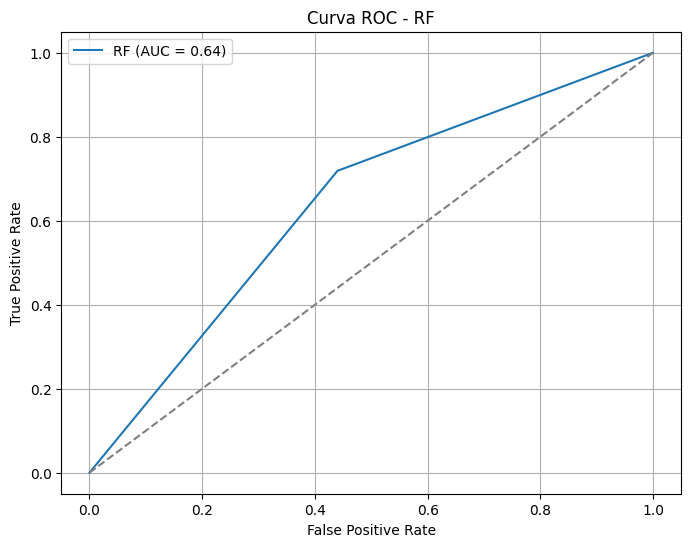

('adc', 't2w')
AUC:  0.6285166240409208
              precision    recall  f1-score   support

           0       0.57      0.52      0.55        23
           1       0.69      0.74      0.71        34

    accuracy                           0.65        57
   macro avg       0.63      0.63      0.63        57
weighted avg       0.64      0.65      0.65        57



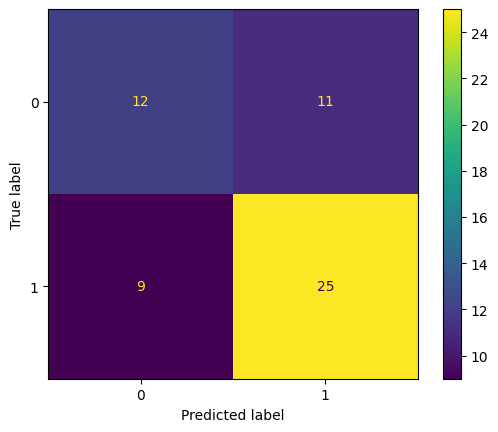

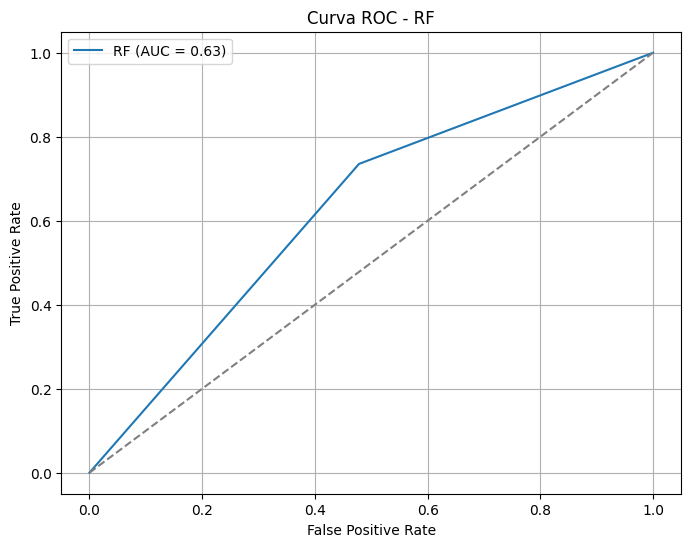

('hbv', 't2w')
AUC:  0.6157635467980296
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        29
           1       0.59      0.71      0.65        28

    accuracy                           0.61        57
   macro avg       0.62      0.62      0.61        57
weighted avg       0.62      0.61      0.61        57



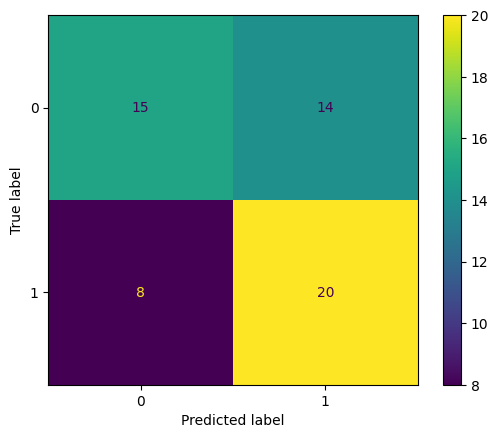

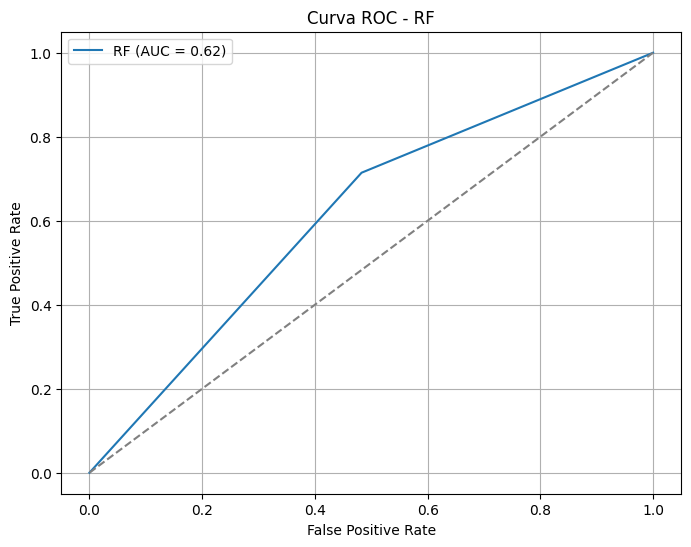

('adc', 'hbv', 't2w')
AUC:  0.5092364532019704
              precision    recall  f1-score   support

           0       0.52      0.48      0.50        29
           1       0.50      0.54      0.52        28

    accuracy                           0.51        57
   macro avg       0.51      0.51      0.51        57
weighted avg       0.51      0.51      0.51        57



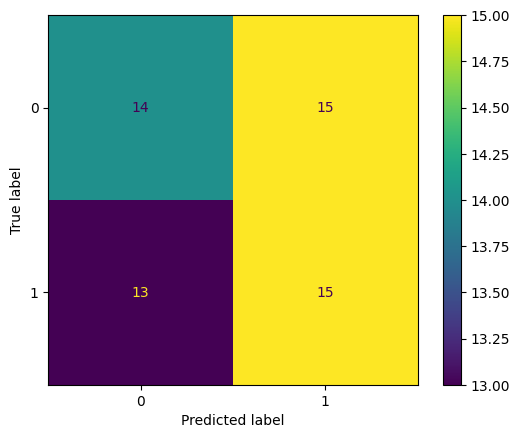

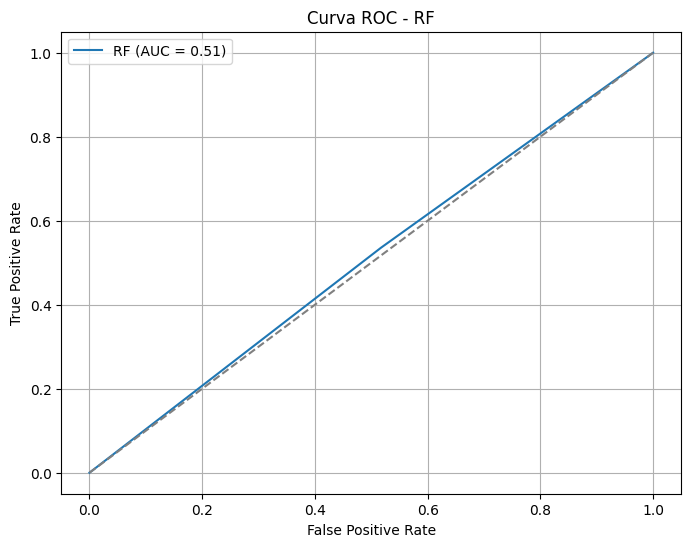

In [70]:
for r in range(4):
    for combo in combinations(['adc', 'hbv', 't2w'], r):
        print(combo)
        df = get_data(sequence=['adc', 'hbv', 't2w'])
        X = df.drop(columns=['is_class1'])
        y = df['is_class1']

        X_scal = MinMaxScaler().fit_transform(X)

        mutual_info_score = mutual_info_classif(X_scal, y, discrete_features=False)
        mi_df = pd.Series(mutual_info_score, index=X.columns).sort_values(ascending=False)
        no_mi = mi_df[mi_df == 0]
        yes_mi = mi_df[mi_df != 0]
        feat_scores = {}

        df2 = df.copy()
        df2.drop(columns=no_mi.keys(), inplace=True)

        X = df2.drop(columns=['is_class1'])
        y = df2['is_class1']

        for col in X.columns:
            g0 = X[y == 0][col]
            g1 = X[y == 1][col]

            stat, p = mannwhitneyu(g0, g1, alternative='two-sided')
            feat_scores[col] = p

        pvals = pd.Series(feat_scores).sort_values()
        pvals = pvals[pvals >= 0.05]

        df3 = df2.copy()
        df3.drop(columns=pvals.keys(), inplace=True)

        X = df3.drop(columns=['is_class1'])
        y = df3['is_class1']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        rf = RandomForestClassifier(min_samples_leaf=4)

        kf = KFold()

        rf_rfe = RFECV(estimator=rf, cv=kf, scoring='recall')
        rf_rfe.fit(X_train, y_train)

        y_pred_rf = rf_rfe.predict(X_test)

        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
        auc_rf = roc_auc_score(y_test, y_pred_rf)

        print('AUC: ', auc_rf)

        print(classification_report(y_true=y_test, y_pred=y_pred_rf))
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=y_pred_rf)).plot()


        # Plot ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {auc_rf:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC - RF')
        plt.legend()
        plt.grid(True)
        plt.show()